In [7]:
#math
import numpy as np
import scipy.stats as stats
import scipy.linalg as linalg
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm

In [8]:
#generate the sample
def gen_data(beta=3):
    nobs = 1000
    x = np.random.uniform(low=-1., high=1., size=nobs)
    e = np.random.uniform(low=-1., high=1., size=nobs) # np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1*(1 + beta * x + e >= 0) 
    return y,x,nobs

In [11]:
def setup_shi(yn,xn):
    model1 = sm.Probit(yn,sm.add_constant(xn))
    model1_fit = model1.fit(disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    grad1 =  model1.score_obs(model1_fit.params)
    hess1 =  model1.hessian(model1_fit.params)
    
    model2 = sm.Logit(yn,sm.add_constant(xn))
    model2_fit = model2.fit(disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    grad2 =  model2.score_obs(model2_fit.params)
    hess2 =  model2.hessian(model2_fit.params)
    
    k1 = len(model1_fit.params)
    k2 = len(model2_fit.params)
    return ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 
    
    
def compute_eigen(yn,xn):
    ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
    hess1 = hess1/len(ll1)
    hess2 = hess2/len(ll2)
    
    k = k1 + k2
    n = len(ll1)
    
    #A_hat:
    A_hat1 = np.concatenate([hess1,np.zeros((k1,k2))])
    A_hat2 = np.concatenate([np.zeros((k2,k1)),-1*hess2])
    A_hat = np.concatenate([A_hat1,A_hat2],axis=1)

    #B_hat, covariance of the score...
    B_hat =  np.concatenate([grad1,-grad2],axis=1) #might be a mistake here..
    B_hat = np.cov(B_hat.transpose())
    #print(B_hat[0:3,3:])
    
    #compute eigenvalues for weighted chisq
    sqrt_B_hat= linalg.sqrtm(B_hat)
    W_hat = np.matmul(sqrt_B_hat,linalg.inv(A_hat))
    W_hat = np.matmul(W_hat,sqrt_B_hat)
    V,W = np.linalg.eig(W_hat)
    return V

n_sims = 5000
yn,xn,nobs = gen_data()
model_eigs = compute_eigen(yn,xn)
eigs_tile = np.tile(model_eigs,n_sims).reshape(n_sims,len(model_eigs))
normal_draws = stats.norm.rvs(size=(n_sims,len(model_eigs)))
weighted_chi = ((normal_draws**2)*eigs_tile).sum(axis=1)
plt.hist(weighted_chi,density=True,bins=25)
plt.show()

TypeError: gen_data() missing 1 required positional argument: 'beta'

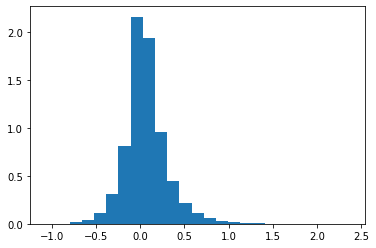

In [10]:
n_sims = 5000
yn,xn,nobs = gen_data(beta=20)
model_eigs = compute_eigen(yn,xn)
eigs_tile = np.tile(model_eigs,n_sims).reshape(n_sims,len(model_eigs))
normal_draws = stats.norm.rvs(size=(n_sims,len(model_eigs)))
weighted_chi = ((normal_draws**2)*eigs_tile).sum(axis=1)
plt.hist(weighted_chi,density=True,bins=25)
plt.show()